1.0
OK norm_pdf_int 0.9997939600000001
OK abs_vol_pdf
FAIL 0.31757777344556803 3.141592653589793
total norm_cdf 1.0


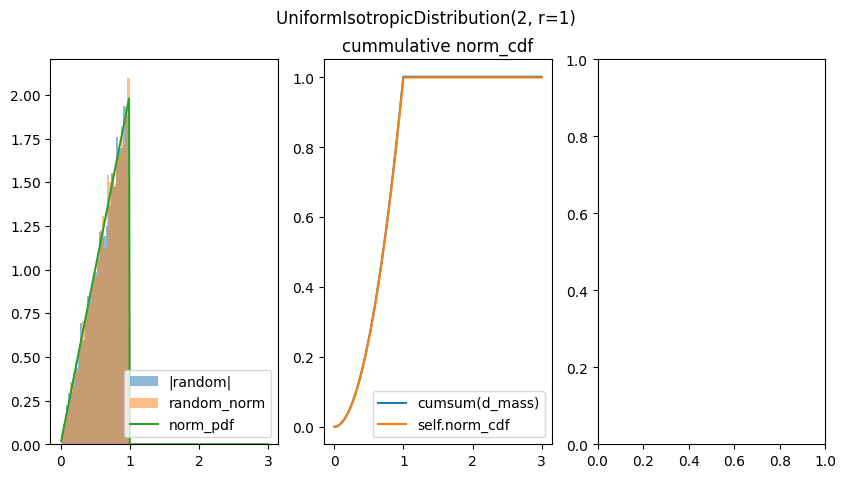

In [297]:

import abc
from typing import Any
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc


def np_where_custom(condition, x, y:float|np.ndarray=0):
    'Like np.where but with x and y having as many elements as the nonzeros of their respective conditions'
    condition = np.asarray(condition)
    out = np.empty_like(condition, dtype=np.result_type(x, y))
    out[condition] = x
    out[~condition] = y
    return out

class Hyperspheres(abc.ABC):
    '''
    norm_cdf and surface of the hyperspheres in R^d.

    Abstract class whose instances are either hard or fuzzy hyperspheres.
    By hard, we refer to a classical hypershpere ocupying a fixed norm_cdf.
    By fuzzy, we refer to an isotropic and unbounded distribution with
    fixed decay function.
    The fuzzy norm_cdf is the total weight of the fuzzy neighborhood
    '''
    
    _cache = {} # class attribute to cache instances
    def __new__(cls, d:int):
        key = (cls.__name__, d)
        obj = cls._cache.get(key)
        if obj is not None:
            return obj
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache[key] = obj
        return obj
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d})"

    def _init(self, d:int): # if it was called __init__, it would be called even if cached 
        assert d==round(d) and d>=1, d
        self.d = d
        'Mass of a unit hypersphere in d dimensions with constant unit density'
        self._volume1 = np.pi**(d/2) / scipy.special.gamma(1 + d/2)
    
    def volume(self, r:float|np.ndarray):
        'volume of the hypersphere in d dimensions with radius r'
        return self._volume1 * r**self.d
    
    def surface(self, r:float|np.ndarray):
        'Surface of the hypersphere in d dimensions with radius r, i.e. (d_volume)/dr'
        return self.d * self._volume1 * r**(self.d-1)
    
    def random_on_surface(self, r:float|np.ndarray=1, size=None):
        'Draw uniformly from the sphere surface'
        r = np.asarray(r).astype(float)
        shape = r.shape if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        X /= r * np.linalg.norm(X, axis=-1, keepdims=True)
        return X
    

class IstotropicDistribution:
    '''
    The total mass is 1 = integral of norm_pdf(r) dr.
    The total volume is the integral of (norm_pdf(r) * space.surface(r)) dr.
    '''


    def __init__(self, d:int, r:float=1.0):
        assert d==round(d) and d>=1, d
        self.space = Hyperspheres(d)
        self.d = d
        self.r = r
        self._post_init()
    
    def _post_init(self):
        pass
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, r={self.r})"
    
    
    @abc.abstractmethod
    def norm_pdf(self, r:float|np.ndarray):
        'Density of |X| for X~self. (r>=0)'
        raise NotImplementedError
    
    def norm_cdf(self, r:float|np.ndarray):
        'total probability norm_cdf in (0,1) that is enclosed in the hypersphere of radius r. (r>=0)'
        raise NotImplementedError
    
    def random(self, size=None):
        'Draw a sample from the distribution'
        X = self.space.random_on_surface(1, size=size)
        X *= self.random_norm(size)[:,None]
        return X
    
    @abc.abstractmethod
    def random_norm(self, size=None):
        raise NotImplementedError
    
    @abc.abstractmethod
    def pointwise_irradiance(self, r:float|np.ndarray):
        '''
        Equals norm_pdf(r) / space.surface(r)
        This is the "euclidean density" in the following sense:
        Fix any point x at radius r, let B(l) be the hypercube of side l centered at x.
        The pointwise_irradiance is the limit as l goes to 0 of the integral of the distribution
        over B(l) divided by the norm_cdf of l.
        '''
        raise NotImplementedError

    def point_weights(self, X:np.ndarray, weights=None, filter_positive=False):
        'Weight each point x in X with its euclidean density'
        # X, counts = np.unique(X, axis=0, return_counts=True)
        norms = np.linalg.norm(X, axis=-1)
        if weights is None:
            weights = np.ones_like(norms)
        weights = weights * self.pointwise_irradiance(norms)
        if filter_positive:
            X = X[weights>0]
            weights = weights[weights>0]
        return X, weights

    @classmethod
    def class_test(cls, d_range:Any=range(1, 11)):
        for d in np.ravel(d_range):
            cls(d).test()
        return
    
    def test(self):
        'Test the formulas used in this class'
        # # Test radial density integral
        N = 10000
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        axes = np.ravel(axes)
        ax = axes[0]
        ax.hist(np.linalg.norm(self.random(N), axis=-1), bins="auto", density=True, alpha=0.5, label='|random|')
        ax.hist(self.random_norm(N), bins="auto", density=True, alpha=0.5, label='random_norm')
        r = np.geomspace(1e-2, 3, 500)
        ax.plot(r, self.norm_pdf(r), label='norm_pdf')
        ax.legend()
        ax= axes[1]
        r = np.linspace(0, 3, 500)
        ax.set_title(f'cummulative norm_cdf')
        d_mass = self.pointwise_irradiance(r) * self.space.surface(r) * np.diff(r, prepend=0)
        ax.plot(r, np.cumsum(d_mass), label='cumsum(d_mass)')
        ax.plot(r, self.norm_cdf(r), label='self.norm_cdf')
        ax.legend()
        # ax= axes[2]
        # # ax.hist(np.abs(self.random(N)[:,0]), bins="auto", density=True, alpha=0.5, label='|random[0]|')
        # r = np.linspace(0, 3, 500)
        # r_c = (r[1:]+r[:-1])/2
        # d_mass = np.diff(self.norm_cdf(r))
        # dvols_ref = self.space.surface(r_c) * np.diff(r)
        # ax.plot(r_c, self.pointwise_irradiance(r_c), label='pointwise_irradiance')
        # ax.plot(r_c, d_mass / dvols_ref, label='dmass / dmass_ref')
        # ax.legend()
        plt.suptitle(f'{self}')
        # Test norm_cdf-radius match
        d_mass = lambda r: self.space.surface(r) * self.pointwise_irradiance(r)
        computed, _ = scipy.integrate.quad(lambda r: d_mass(r), 0, np.inf)
        attr = self.norm_cdf(self.r*10)
        assert np.isclose(attr, computed), (attr, computed)
        print('total norm_cdf', attr)
        attr = 1
        computed, _ = scipy.integrate.quad(lambda r: self.norm_pdf(r), 0, np.inf)
        assert np.isclose(attr, computed), (attr, computed)
        return
    
    # def mass_inclusion(self, r:float):
    #     'Proportion of the norm_cdf of radius r that lies inside self. (r>=0)'
    #     raise NotImplementedError
    
    # def large_radius(self, alpha=0.95):
    #     'radius for which the inclusion is at most 1 - alpha'
    #     return 1

# UniformIsotropicDistribution(3).test()


class UniformIsotropicDistribution(IstotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._c = 1/self.space.volume(self.r)
    
    def norm_cdf(self, r:float|np.ndarray):
        r = np.clip(0., self.r, r)
        return self._c * self.space.volume(r)
    
    def norm_pdf(self, r:float|np.ndarray):
        r = np.asarray(r).astype(float) /self.r
        return (r<=1) * self.d * r**(self.d-1) / self.r
    
    def random_norm(self, size=None):
        return np.random.random(size)**(1/self.d) * self.r

    def pointwise_irradiance(self, r:float|np.ndarray):
        r = np.asarray(r).astype(float) / self.r
        return np.where(r<=1, self._c, 0.0)
    
    def test(self):
        r = np.linspace(0, self.r*1.1, 501)[1:]
        norm_pdf_int = np.trapz(self.norm_pdf(r), x=r)
        ok = np.isclose(norm_pdf_int, 1, atol=1e-3, rtol=1e-3)
        print('OK' if ok else 'FAIL', 'norm_pdf_int', norm_pdf_int)
        
        abs_vol_pdf_ref = self.norm_pdf(r) / self.space.surface(r)
        abs_vol_pdf = self.pointwise_irradiance(r)
        ok = np.allclose(abs_vol_pdf, abs_vol_pdf_ref, atol=1e-3, rtol=1e-3)
        if not ok:
            plt.plot(r, abs_vol_pdf_ref, label='abs_vol_pdf_ref')
            plt.plot(r, abs_vol_pdf, label='abs_vol_pdf')
            plt.legend()
            plt.show()
            print(abs_vol_pdf)
        print('OK' if ok else 'FAIL', 'abs_vol_pdf')

        total_vol = np.trapz(abs_vol_pdf, x=r)
        ref_vol = self.space.volume(self.r)
        ok = np.isclose(total_vol, ref_vol, atol=1e-3, rtol=1e-3)
        print('OK' if ok else 'FAIL', total_vol, ref_vol)
        super().test()

class GaussianIsotropicDistribution(IstotropicDistribution):

    def __init__(self, d:int, r:float|None=None, sigma:float|None=None):
        self.d = d
        if r is None and sigma is None:
            r = 1
        elif r is None:
            sigma = 1
            r = np.nan
        # self.__vol_factor = scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)
        self.r = r #* self.__vol_factor ** (-1/self.d)
        self.__rv_no_scale:scipy.stats.rv_continuous = scipy.stats.chi(self.d) # type:ignore
        self.total_mass = self.space.volume(1) * self.r**self.d * self.__rv_no_scale.moment(self.d)
        # norm_cdf factor for isotropic gaussian if sigma was 1
        # Radius (i.e. sigma) so that the norm_cdf equals the uniform hypersphere
    
    def random(self, size=None):
        shape = () if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.r
    
    def random_norm(self, size=None):
        return self.__rv_no_scale.rvs(size) * self.r

    def pointwise_irradiance(self, r:float|np.ndarray):
        r = np.asarray(r).astype(float) / self.r
        return 1 - self.__rv_no_scale.cdf(r)

    def norm_pdf(self, r:float|np.ndarray):
        'Density for the prob. that a point chosen uniformly from the hypersphere (norm_cdf) has radius r. (r>=0)'
        r = np.asarray(r).astype(float)
        return self.__rv_no_scale.pdf(r / self.r) / self.r

    def norm_cdf(self, r:float|np.ndarray):
        return self.total_mass * np.ones_like(r)
    



dist = UniformIsotropicDistribution(2, r=1)
print(dist.norm_cdf(100))
dist.test()


In [ ]:

# For exponential, I would need to derive the formulas...


class ExponentialHypersphere(IstotropicDistribution):

    def _init(self, d: int):
        super()._init(d)
        # COPIED FROM GAUSSIAN, but it's WRONG
        
        # Volume factor for isotropic gaussian if sigma was 1
        self._vol_factor = scipy.special.gamma(1 + (d-1)/2) * 2**(3*d/2 - 1) / np.sqrt(np.pi)
        # Radius (i.e. sigma) so that the volume equals the uniform hypersphere
        self._R = self._vol_factor ** (-1/self.d)
    
    def random_radius(self, size=None):
        return np.random.exponential(size=size)

    def radius_density(self, r:float|np.ndarray):
        'Density for the prob. that a point chosen uniformly from the hypersphere (volume) has radius r. (r>=0)'
        return scipy.stats.expon().pdf(r/self._R) * self._R # type:ignore
    
    def surface_inclusion(self, r: float):
        # FAILS:
        return 1 - scipy.stats.expon().cdf(r/self._R)
    
ExponentialHypersphere.class_test()


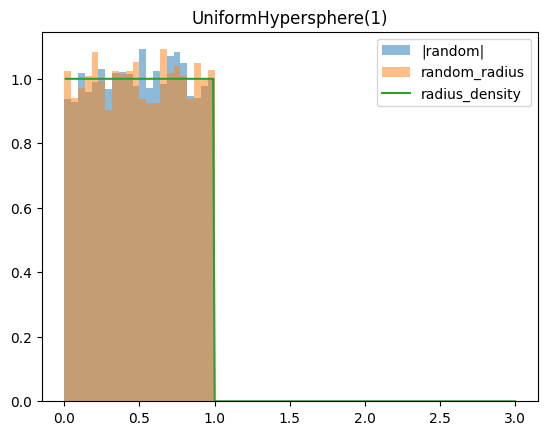

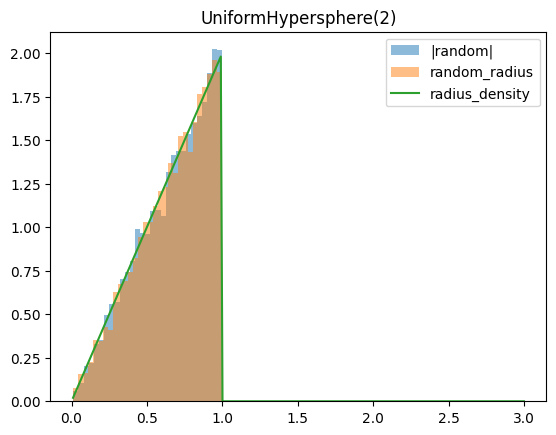

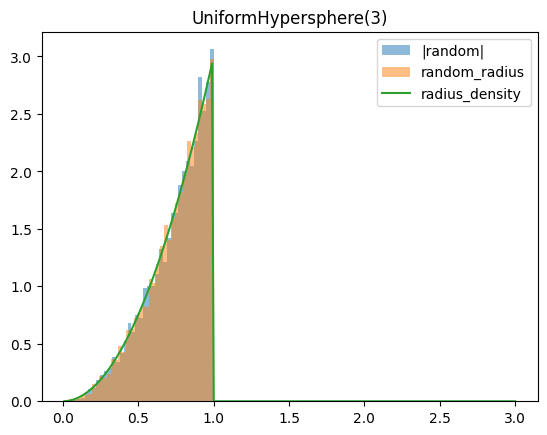

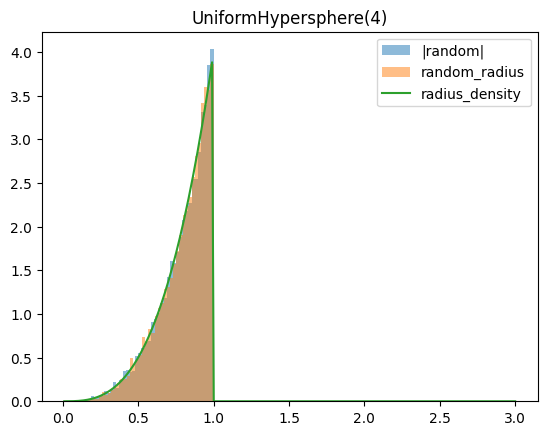

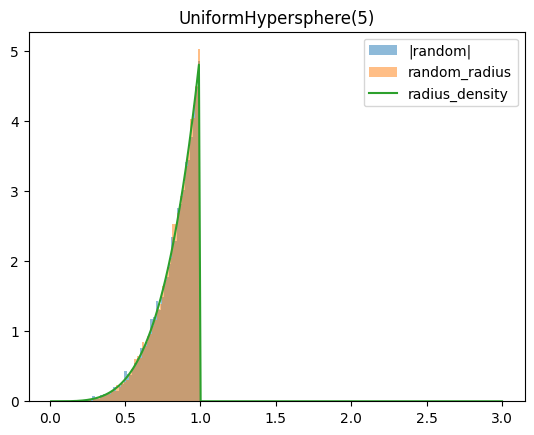

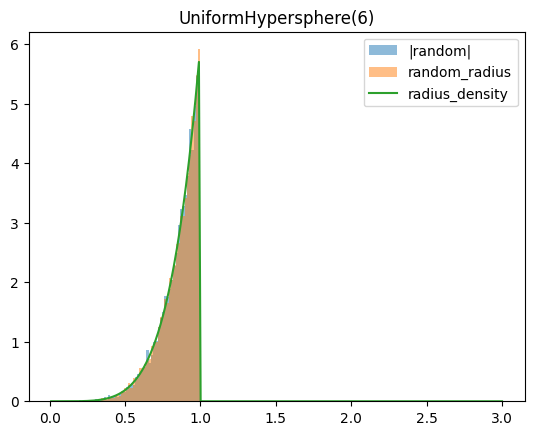

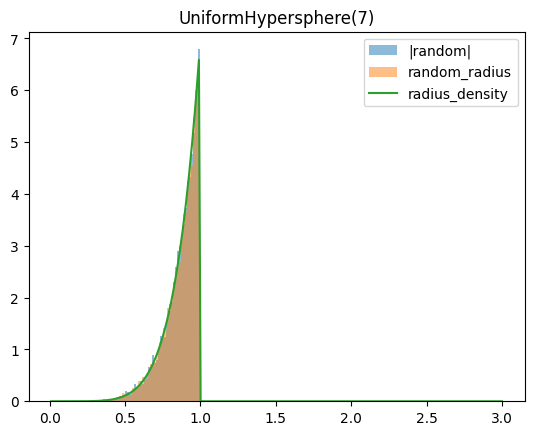

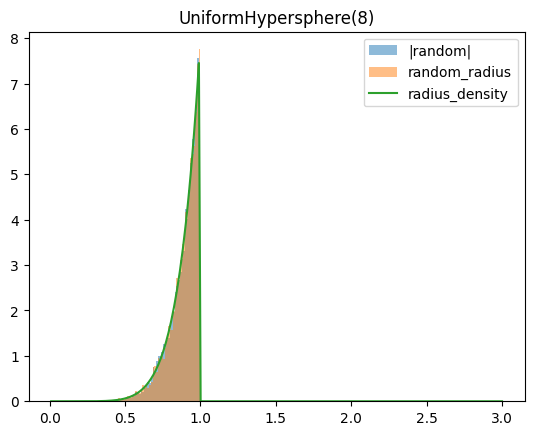

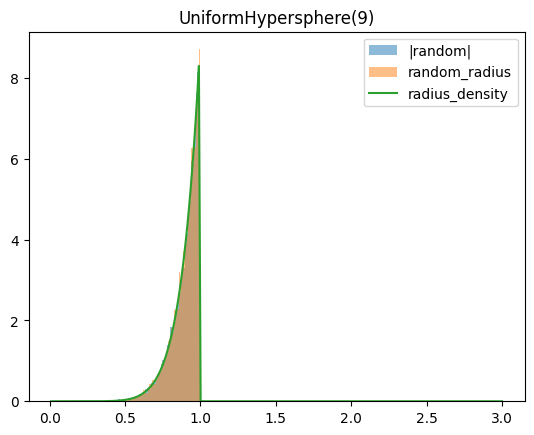

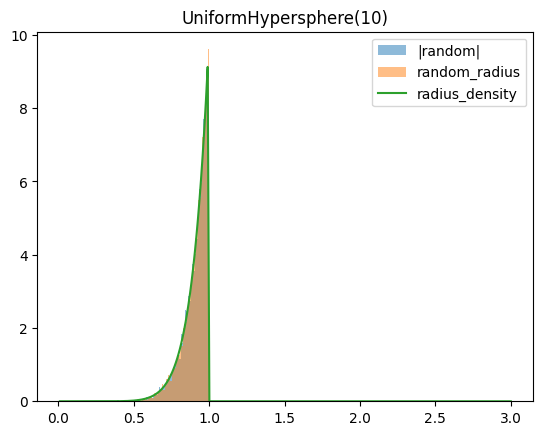

In [3]:

UniformHypersphere.class_test()


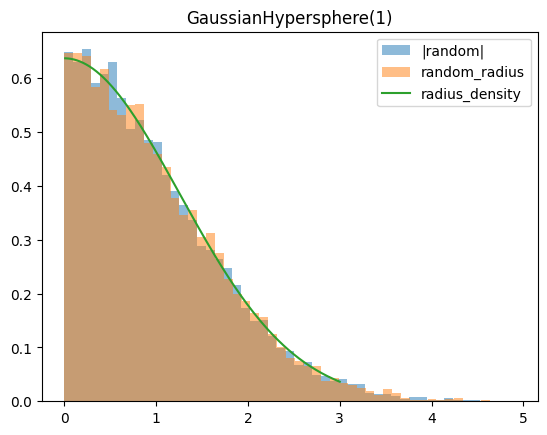

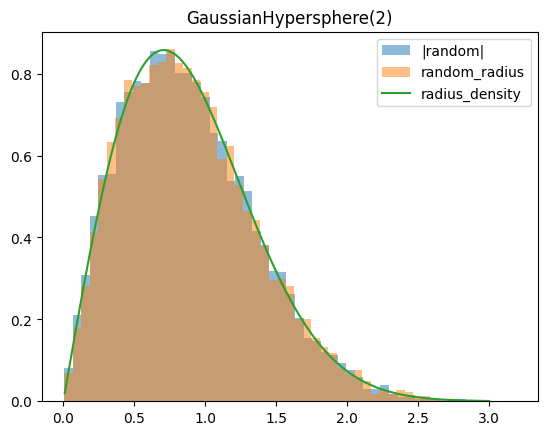

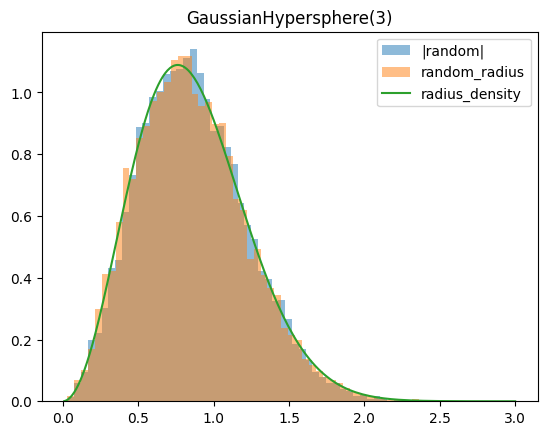

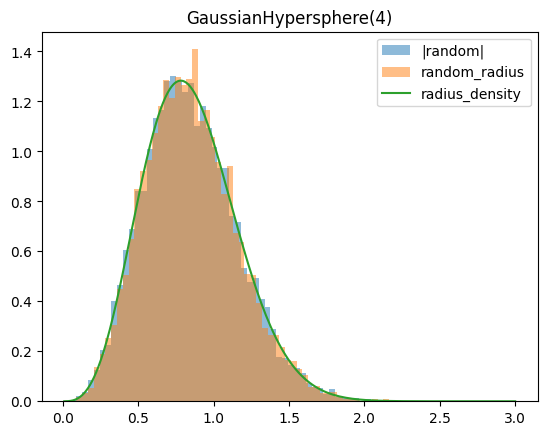

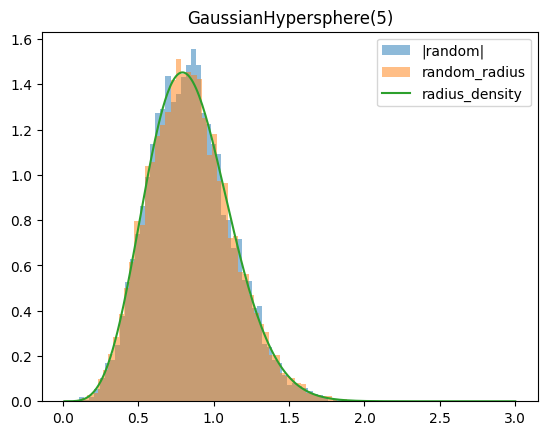

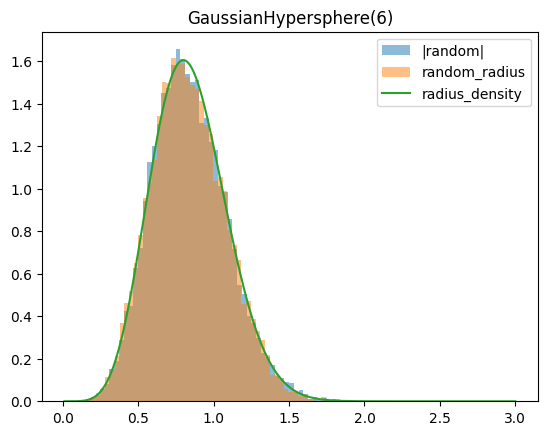

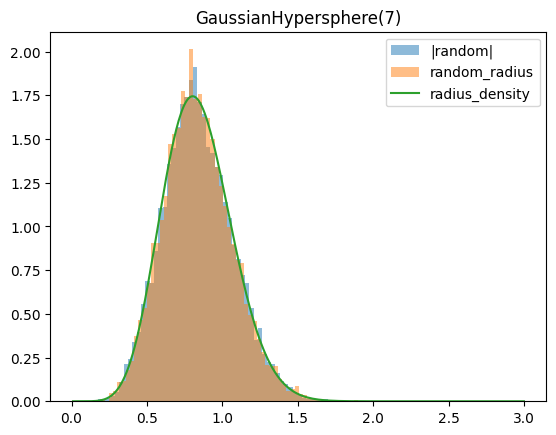

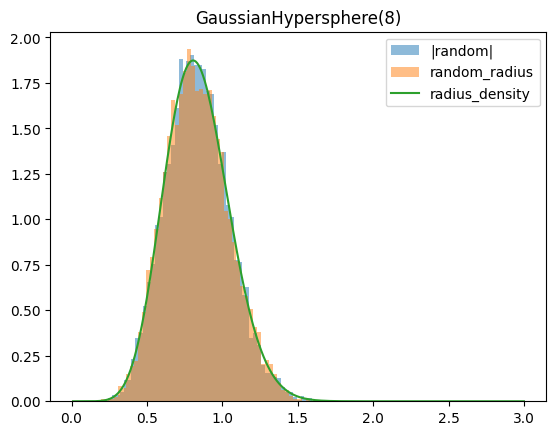

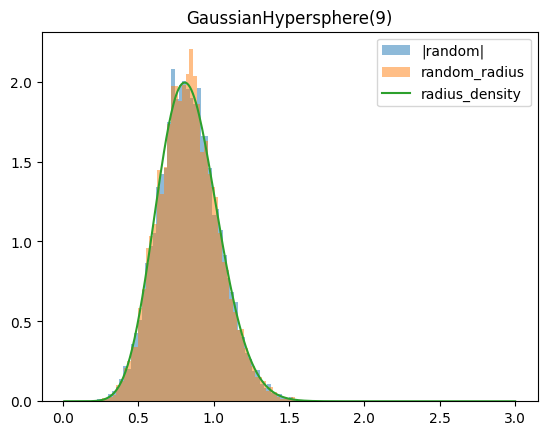

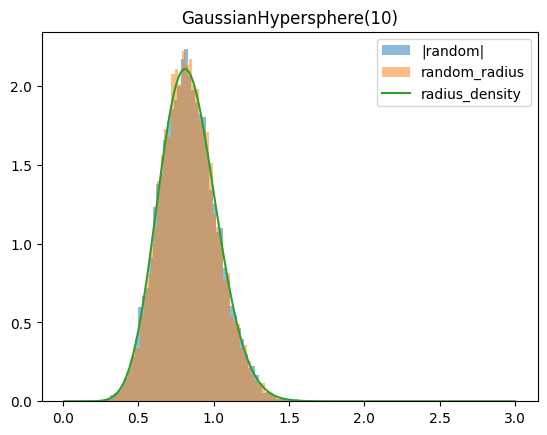

In [4]:

GaussianHypersphere.class_test()

In [ ]:
'''
OLD DOCSTRING:

Volume and surface of hard and fuzzy hyperspheres in R^d
By hard, we refer to a classical hypershpere
By fuzzy, we refer to an isotropic and unbounded distribution with
fixed decay function.
    Currently, I am using 1-chi(d).cdf(r) as the decay function,
    because at some point of my reasoning about neighborhoods, I was needing
    probabilities instead of densities at each radius, so I used the chi distribution
    with the formula above, which measures the mass of gaussian noise lying outside the
    hypersphere of d dimensions and radius r.
    I am thinking of changing it to a gaussian decay, but I should check
    if the rest of the code is compatible with a change.
The fuzzy volume is the total weight of the fuzzy neighborhood
'''
